# Case study 1: Simulation with a SARS-CoV-2 Model

In [1]:
pip install git+https://github.com/y0-causal-inference/eliater.git 

  Cloning https://github.com/y0-causal-inference/eliater.git to /private/var/folders/fs/kx46_43x04ndj3yryggvkg5r0000gn/T/pip-req-build-zo02086b
  Running command git clone --quiet https://github.com/y0-causal-inference/eliater.git /private/var/folders/fs/kx46_43x04ndj3yryggvkg5r0000gn/T/pip-req-build-zo02086b
  Resolved https://github.com/y0-causal-inference/eliater.git to commit 33eb330e6faaa0fce6a0526d4764b800b1c8434c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np

# from eliater import version_df
from eliater.discover_latent_nodes import find_nuisance_variables, remove_nuisance_variables
from src.eliater.examples.sars_cov2 import sars_large_example as example
from eliater.network_validation import print_graph_falsifications
from y0.algorithm.estimation import estimate_ace
from y0.algorithm.identify import Identification, identify_outcomes
from y0.dsl import P, Variable

# version_df()

In [32]:
treatment = Variable("EGFR")
outcome = Variable("cytok")
SEED = 1

This is case study 1 in Figure 6 in this paper: Eliater: an open source software for causal query estimation from observational measurements of biomolecular networks. The figure below shows the SARS-CoV-2 network (Mohammad-Taheri et al., 2022; Zucker
et al., 2021), which models the activation of Cytokine Release Syndrome (Cytokine Storm), a known factor causing tissue damage in severely ill SARS-CoV-2 patients (Ulhaq and Soraya, 2020).

![sars](../img/SARS_COV.png)

In [33]:
graph = example.graph

This case study used synthetic observational data. The generation of this synthetic data was inspired by common biological practices.  The exogenous variables were modeled with a Gaussian distribution. For each endogenous variable $X$, we represented  biomolecular reactions using Hill equations \cite{alon2019introduction}, and were approximated with a sigmoid function as follows,

$\mathcal{N}(\frac{100}{1 + \exp(\mathbf{\theta}^{\prime} Pa(X) + \theta_0)})$ 

where $Pa(X)$ is a $q \times 1$ vector of measurements related to the parent of $X$, $\mathbf{\theta}'$ is a $1 \times q$ parameter vector, and $\theta_0$ is a scalar. The $EGFR$ was generated from a Binomial distribution with probability of $\frac{1}{1 + \exp(\mathbf{\theta}^{\prime} Pa(X) + \theta_0)}$. Hence, the observational data is mixed-type where the $EGFR$ column is binary (discrete), and rest of columns are continuous.

In [34]:
# get observational data
#data = example.generate_data(1000, seed=SEED)
data = example.generate_data(1000, seed=SEED)
data.head()

,SARS_COV2,ACE2,Ang,AGTR1,ADAM17,Toci,Sil6r,EGF,TNF,Gefi,EGFR,PRR,NFKB,IL6STAT3,IL6AMP,cytok
0,59.369823,28.865010,80.945934,98.951365,99.622929,46.948396,72.362190,97.811656,98.636874,48.455842,1,93.522042,31.738214,38.304913,44.590550,66.890970
1,65.747677,24.442393,88.638279,100.485450,98.100064,53.387180,66.974700,98.118165,99.194269,53.216181,1,93.253347,32.373436,13.011949,28.977027,45.865472
2,50.159966,38.743537,63.744807,96.905832,98.596068,44.723507,80.906965,99.105551,99.680357,48.304371,1,89.229004,28.464979,38.081135,45.681853,68.698542
3,56.522754,31.391726,80.738942,99.529963,97.361924,52.824318,71.810154,97.007089,100.493854,31.968428,1,90.428579,32.031291,38.437000,46.039039,69.361123
4,68.088783,23.650945,90.055546,97.717794,99.504007,19.245570,88.271677,97.318417,101.467959,54.053559,1,94.705816,42.688960,36.909011,49.313341,75.695476


In [35]:
import numpy as np
np.mean(data['EGFR'])

0.807

## Step 1: Verify correctness of the network structure

We checked the consistency of the network structure against observational data with significance level of 0.01 by first discretizing the data into a binary data and used the $\chi$-square test. This is because \texttt{Eliater} does not support mixed-type data.  

In [36]:
from sklearn.preprocessing import KBinsDiscretizer
# discretization transform the raw data
kbins = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='uniform')
data_trans = kbins.fit_transform(data)

In [37]:
import pandas as pd
data_trans = pd.DataFrame(data_trans, columns = data.columns)

In [38]:
data_trans

,SARS_COV2,ACE2,Ang,AGTR1,ADAM17,Toci,Sil6r,EGF,TNF,Gefi,EGFR,PRR,NFKB,IL6STAT3,IL6AMP,cytok
0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
1,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
3,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
4,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
996,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
997,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
998,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0


In [39]:
print_graph_falsifications(
    graph=graph, data=data_trans, method="chi-square", verbose=True, significance_level=0.01
)

Failed tests: 11/99 (11.11%)
Reject null hypothesis when p<0.01
=========  =========  ===============  =============  =============  =====  =============  ===================
left       right      given                    stats              p    dof          p_adj  p_adj_significant
=========  =========  ===============  =============  =============  =====  =============  ===================
ACE2       PRR        SARS_COV2         81.4172         0                1    0            True
Ang        PRR        SARS_COV2        127.143          0                1    0            True
Sil6r      cytok      IL6AMP            88.0579         0                1    0            True
IL6STAT3   cytok      IL6AMP            49.2213         2.2865e-12       1    2.19504e-10  True
Ang        NFKB       ADAM17|PRR        53.5342         2.37244e-12      2    2.25381e-10  True
NFKB       SARS_COV2  ADAM17|PRR        48.1146         4.02023e-12      1    3.77901e-10  True
AGTR1      PRR        SARS_CO

Among all the 99 possible tests, 10 failed (10 $\%$). As the data was synthetically generated based on the network structure, we expected all the tests to pass. However the failed tests are due to noise inherited by randomly sampling the data points. 

## Step 2: Check query identifiability

In [40]:
identify_outcomes(graph=graph, treatments=treatment, outcomes=outcome)

Sum[ACE2, ADAM17, AGTR1, Ang, IL6AMP, IL6STAT3, NFKB, PRR, SARS_COV2, Sil6r, TNF, Toci](P(ACE2 | SARS_COV2) * P(AGTR1 | ACE2, Ang, SARS_COV2) * P(IL6AMP | ACE2, ADAM17, AGTR1, Ang, EGF, EGFR, Gefi, IL6STAT3, NFKB, PRR, SARS_COV2, Sil6r, TNF, Toci) * P(IL6STAT3 | ACE2, ADAM17, AGTR1, Ang, SARS_COV2, Sil6r, Toci) * P(TNF | ACE2, ADAM17, AGTR1, Ang, SARS_COV2) * P(cytok | ACE2, ADAM17, AGTR1, Ang, EGF, EGFR, Gefi, IL6AMP, IL6STAT3, NFKB, PRR, SARS_COV2, Sil6r, TNF, Toci) * Sum[ACE2, ADAM17, AGTR1, Ang, EGF, EGFR, Gefi, IL6AMP, IL6STAT3, NFKB, PRR, SARS_COV2, Sil6r, TNF, cytok](P(ACE2, ADAM17, AGTR1, Ang, EGF, EGFR, Gefi, IL6AMP, IL6STAT3, NFKB, PRR, SARS_COV2, Sil6r, TNF, Toci, cytok)) * P(ADAM17 | ACE2, AGTR1, Ang, SARS_COV2, Toci) * P(Sil6r | ACE2, ADAM17, AGTR1, Ang, SARS_COV2, Toci) * P(Ang | ACE2, SARS_COV2) * P(SARS_COV2) * P(NFKB | ACE2, ADAM17, AGTR1, Ang, EGF, EGFR, Gefi, PRR, SARS_COV2, TNF) * P(PRR | ACE2, Gefi, SARS_COV2))

The query is identifiable.

## Step 3: Find nuisance variables and mark them as latent

This function finds the nuisance variables for the input graph.

In [41]:
nuisance_variables = find_nuisance_variables(graph, treatments=treatment, outcomes=outcome)
nuisance_variables

set()

No variable is identified as the nuisance variable. Hence the simplified network in the next step will produce a graph similar to the original graph.

## Step 4: Simplify the network

In eliater, step 3, and 4 are both combined into a single function. Hence, the following function finds the nuisance variable (step 3), marks them as latent and then applies Evan's simplification rules (Step 4) to remove the nuisance variables. As a result, running the 'find_nuisance_variables' and 'mark_nuisance_variables_as_latent' functions is not necessary to get the value of step 4. However, we called them to illustrate the results.  As there are no nuisance variables, the new graph will be the same as the original graph.

In [42]:
new_graph = remove_nuisance_variables(graph, treatments=treatment, outcomes=outcome)

## Step 5: Estimate the query

In [43]:
estimate_ace(new_graph, treatments=treatment, outcomes=outcome, data=data)

0.40458569285088686

## Evaluation criterion
As we used synthetic data set, we were able to generate two interventional data sets where in
one EGFR was set to 1, and the other one EGFR is set to 0. The ATE was calculated by subtracting the average value of Cytokine Storm obtained from each interventional data,
resulting in the ground truth ATE=0.796. The positive ATE indicates that the Gefitinib drug can not reduce the Cytokine Storm levels, hence can't help in treating patients having SARS-Cov-2.

In [44]:
def get_background_ace(seed=None) -> float:
    # get interventional data where treatment is set to 1
    data_1 = example.generate_data(1000, {treatment: 1.0}, seed=seed)
    # get interventional data where treatment is set to 0
    data_0 = example.generate_data(1000, {treatment: 0.0}, seed=seed)
    return data_1.mean()[outcome.name] - data_0.mean()[outcome.name]

# get the true value of ATE
get_background_ace(seed=SEED)

0.7961491870724515

The estimated $\widehat{\mathrm{ATE}}=0.605$, comparable in sign and magnitute to the ground truth ATE=0.796. The discrepancy in the value of results is due to non-linear, and complex data generation procedure, which is similar to the real-life experimental artifacts, and due to the approximate nature of the modeling assumption.

In [11]:
#Relative change
((0.605 - 0.796)/0.796)

-0.23994974874371866

### Random Sampling Evaluation

In [45]:
# Population => Generate D = 10000 data points
D = example.generate_data(10000, seed=SEED)

In [49]:
# Samples => Generate 1000 datasets with 1000 points each (d) using random sampling
d_count = 1000
d_size = 1000
d = [D.sample(d_size) for _ in range(d_count)]

In [50]:
ate = [estimate_ace(new_graph, treatments=treatment, outcomes=outcome, data=data) for data in d]

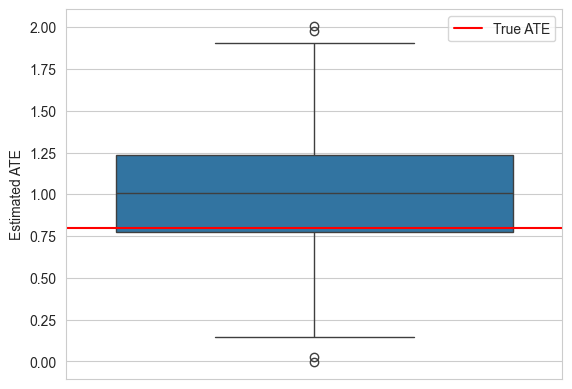

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.boxplot(y=ate)
ax.axhline(y=get_background_ace(seed=SEED), label="True ATE", color='r')
ax.set(ylabel="Estimated ATE")
ax.legend()
#plt.savefig("/Users/sarataheri/GitHub/eliater/img/Sars_ATE_boxplot.png")